In [1]:
import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 

import sys 
sys.path.append('../..')
from delphi.stats.linear_regression import TruncatedRegression
from delphi.oracle import Left
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata

OUT_DIR = '/home/gridsan/stefanou/Regression/Cosine'
TABLE_NAME = 'logs'
# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [2]:
args = Parameters({
    "bias": True,
    "samples": 1000,
    "c": 0,
    "batch_size": 5,
    "lr": 1e-1,
    "var_lr": 1e-2,
    "var_": 1,
    "trials": 3,
    "norm": False,
    "workers": 8,
    "steps": 1000,
#     "step_lr": 1,
#     "step_lr_gamma": 1.0,
    "custom_lr_multiplier": consts.COSINE,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
    "device": "cuda",
    "num_samples": 100,
})
mse_loss = ch.nn.MSELoss()

I will start by generating the ground-truth for our expriment.

gt weight:  Parameter containing:
tensor([[-0.5836]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[0.6655]], requires_grad=True)
alpha:  tensor([0.5780])
gt ols coef:  [[-0.5690562]]
gt ols intercept:  [0.6313461]
trunc ols coef:  [[-0.28112447]]
trunc ols intercept:  [2.1720827]


Text(0, 0.5, 'y')

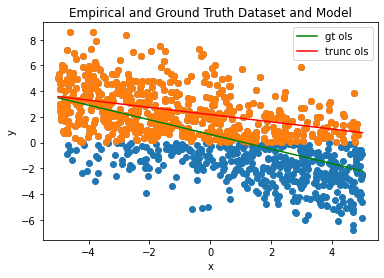

In [3]:
# distribution for generating feature vectors
d, k = 1, 1
w = Uniform(-1, 1)
# m = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
m = Uniform(-5, 5)
phi = Left(Tensor([0.0]))

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None

print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))

    y = gt(X)

noise_var = Tensor([5.0])[...,None]
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
    # truncate based off of the standardized data
    indices = phi(noised).nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(-5, 5, 100).reshape(100, 1)
norm_data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we want to standardize our truncated dataset, so that our empirical estimates are located on the l2 ball. First we will divide all of our covariate features by $B\sqrt{k}$, so that all of our covariate features $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. This way the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [4]:
max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(4.9963)
beta:  tensor(4.9963)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. So, now we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1. First, let's calculate the predicted values from our naive ols regression on teh truncated data.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([2.7054])
trunc reg noise var:  tensor([1.0000])


Text(0, 0.5, 'y')

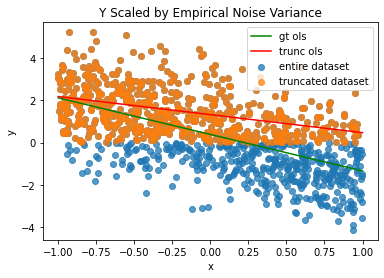

In [5]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)

emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

new_X, emp_stand_noised = X / beta, noised / ch.sqrt(emp_noise_var)

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(new_X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc_norm, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

First, we will standardize our data for the case where we assume that wee know the underlying ground-truth noise variance.

Text(0, 0.5, 'y')

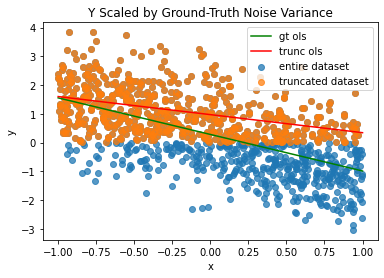

In [6]:
stand_noised, stand_y_trunc = noised / ch.sqrt(noise_var), y_trunc / ch.sqrt(noise_var)

gt_stand = LinearRegression()
gt_stand.fit(new_X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc_norm, stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Empirical Variance

In [21]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, args=args, bias=True, var=ch.ones(1))
known_emp_res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
known_emp_w_unnorm, known_emp_bias_unnorm = (known_emp_res.weight * ch.sqrt(emp_noise_var)) / beta, (known_emp_res.bias * ch.sqrt(emp_noise_var))

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

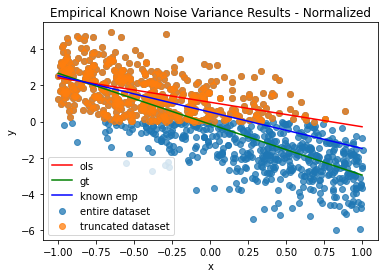

Text(0, 0.5, 'y')

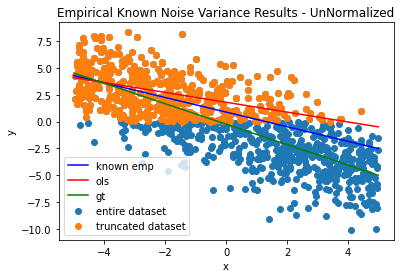

In [22]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_emp_res(Tensor(norm_data)).detach().numpy(), label='known emp', color='blue')
plt.legend()
plt.title("Empirical Known Noise Variance Results - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), color='blue', label='known emp')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Variance

In [31]:
args.__setattr__('steps', 1000)
args.__setattr__('batch_size', 10)

trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, args=args, bias=True, var=ch.ones(1))
known_res = trunc_reg.fit(x_trunc_norm, stand_y_trunc)
known_weight_unnorm, known_bias_unnorm = (known_res.weight * ch.sqrt(noise_var)) / beta, known_res.bias * ch.sqrt(noise_var)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

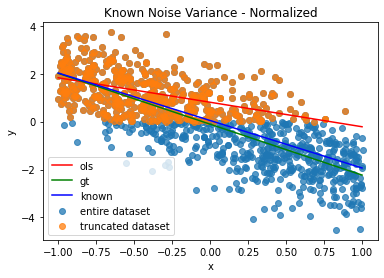

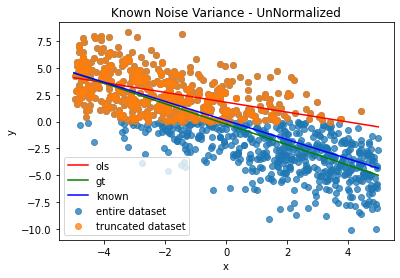

In [32]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_res(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_weight_unnorm + known_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [ ]:
args.__setattr__('steps', 1000)
args.__setattr__('batch_size', 25)
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, args=args, bias=True)
unknown_res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
unknown_var = unknown_res.lambda_.inverse()
unknown_weight_unnorm, unknown_bias_unnorm = (((unknown_res.weight * unknown_var) * ch.sqrt(emp_noise_var)) / beta).detach().numpy(), ((unknown_res.bias * unknown_var) * ch.sqrt(emp_noise_var)).detach().numpy()

> /home/gridsan/stefanou/delphi/delphi/grad.py(99)backward()
     97     def backward(ctx, grad_output):
     98         import pdb; pdb.set_trace()
---> 99         pred, targ, lambda_ = ctx.saved_tensors
    100         # calculate std deviation of noise distribution estimate
    101         sigma = ch.sqrt(lambda_.inverse())

ipdb> n
> /home/gridsan/stefanou/delphi/delphi/grad.py(101)backward()
     99         pred, targ, lambda_ = ctx.saved_tensors
    100         # calculate std deviation of noise distribution estimate
--> 101         sigma = ch.sqrt(lambda_.inverse())
    102         stacked = pred[None, ...].repeat(config.args.num_samples, 1, 1)
    103         # add noise to regression predictions

ipdb> sigma
*** NameError: name 'sigma' is not defined
ipdb> n
> /home/gridsan/stefanou/delphi/delphi/grad.py(102)backward()
    100         # calculate std deviation of noise distribution estimate
    101         sigma = ch.sqrt(lambda_.inverse())
--> 102         stacked = pred[None,

ipdb> n
> /home/gridsan/stefanou/delphi/delphi/grad.py(106)backward()
    104         noised = stacked + sigma * ch.randn(stacked.size()).to(config.args.device)
    105         # filter out copies that fall outside of truncation set
--> 106         filtered = ch.stack([config.args.phi(batch)[..., None].float() for batch in noised])
    107         z = noised * filtered
    108         lambda_grad = .5 * (targ.pow(2) - (z.pow(2).sum(dim=0) / (filtered.sum(dim=0) + config.args.eps)))

ipdb> noised.size()
torch.Size([100, 25, 1])
ipdb> sigma 
tensor([[1.0000]])
ipdb> sigma * ch.randn(stacked.size())
tensor([[[-0.1814],
         [ 0.0808],
         [-0.1311],
         ...,
         [ 0.6267],
         [-0.5009],
         [-0.1674]],

        [[-0.5371],
         [-0.8692],
         [-1.0351],
         ...,
         [ 0.7114],
         [ 1.1075],
         [-0.8918]],

        [[ 2.8242],
         [-0.5051],
         [ 0.1872],
         ...,
         [-0.2736],
         [-0.8594],
         [

ipdb> filtered == (noised > 0)
tensor([[[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]],

        [[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]],

        [[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]],

        ...,

        [[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]],

        [[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]],

        [[True],
         [True],
         [True],
         ...,
         [True],
         [True],
         [True]]])
ipdb> ch.all(filtered == (noised > 0))
tensor(True)
ipdb> targ > 0
tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
    

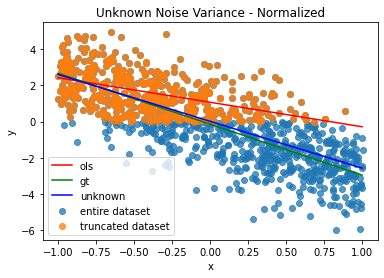

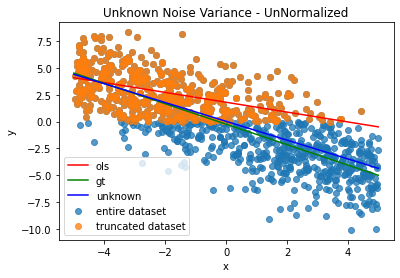

In [34]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, unknown_res(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
plt.legend()
ax.set_title("Unknown Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight_unnorm + unknown_bias_unnorm), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Truncate at Zero and Run for High Variance

In [3]:
args.__setattr__('batch_size', 1)

In [23]:
# expriment parameters
w_lower, w_upper = -1, 1
d, k = 1, 1

for i in range(args.trials):
    # create store and add table
    store = Store(OUT_DIR)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_mse': float,
        'known_emp_r2': float,
        'known_emp_param_mse': float,
        'known_emp_time': int,
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_mse': float,
        'unknown_time': int,
        'alpha': float, 
        'num_samples': int,
        'noise_scale': float, 
    })

    # distribution for generating feature vectors
    w = Uniform(w_lower, w_upper)
    dist = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
    phi = Left(Tensor([0.0]))
    
    # generate ground truth
    gt = ch.nn.Linear(in_features=d, out_features=k)
    gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))
    gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None
    
    # create base classifier
    with ch.no_grad():
        # generate data
        X = dist.sample(ch.Size([args.samples]))
        y = gt(X)
        rand_noise = ch.randn(X.size(0), 1)
        
    for noise_var in range(1, 11): 
        noise_var = Tensor([noise_var])[None,...]
        # add noise to ground-truth pedictions
        noised = y + ch.sqrt(noise_var) *rand_noise
        # truncate based off of the standardized data
        indices = phi(noised).nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = Tensor([y_trunc.size(0) / args.samples])
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(x_trunc.size(1))
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        print("gt params: ", gt_params)
        print("gt var: ", noise_var)
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)
        


        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_param_mse': mse_loss(ols_params, gt_params),
            'ols_var_mse': mse_loss(ols_var, noise_var), 
        })
        
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc_norm)).var(0)
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)
        # standardize noised by the empirical noise variance
        emp_stand_noised = noised / ch.sqrt(emp_noise_var)
        
        trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, args=args, bias=args.bias, var=ch.ones(1))
        st = datetime.datetime.now()
        known_emp_results = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
        w, w0 = (known_emp_results.weight.detach().cpu() * ch.sqrt(emp_noise_var)) / beta, known_emp_results.bias.detach().cpu()[..., None] * ch.sqrt(emp_noise_var)
        known_emp_params = ch.cat([w, w0], dim=1).flatten()
        # known emp results
        store[TABLE_NAME].update_row({
            'known_emp_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'known_emp_param_mse': mse_loss(known_emp_params, gt_params),
            'known_emp_time': int((datetime.datetime.now() - st).total_seconds()), 
        })
        
        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by the empirical noise variance
        stand_y_trunc = y_trunc / math.sqrt(noise_var)
        # standardize noised by the empirical noise variance
        stand_noised = noised / math.sqrt(noise_var)
        trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, args=args, bias=args.bias, var=ch.ones(1))
        st = datetime.datetime.now()
        known_results = trunc_reg.fit(x_trunc_norm, stand_y_trunc)
        w, w0 = (known_results.weight.detach().cpu() * ch.sqrt(noise_var)) / beta, known_results.bias.detach().cpu()[..., None] * ch.sqrt(noise_var)
        known_params = ch.cat([w, w0], dim=1).flatten()
        # known results
        store[TABLE_NAME].update_row({
            'known_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'known_param_mse': mse_loss(known_params, gt_params),
            'known_time': int((datetime.datetime.now() - st).total_seconds()), 
        })
        
        print("known weight grad: ", known_results.weight.grad)
        print("known bias grad: ", known_results.bias.grad)
        
        # truncated regression with unknown variance
#         args.__setattr__('batch_size', 25)
        trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, args=args, bias=args.bias)
        st = datetime.datetime.now()
        unknown_results = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
        var_ = unknown_results.lambda_.inverse()
        unknown_var = var_.cpu() * ch.sqrt(emp_noise_var)
        w, w0 = (((unknown_results.weight.cpu() * var_) * ch.sqrt(emp_noise_var)) / beta).detach(), ((unknown_results.bias.cpu() * var_) * ch.sqrt(emp_noise_var)).detach()
        unknown_params = ch.cat([w, w0], dim=1).flatten()
        
        print("unknown var: ", unknown_var)
        print("unknown params: ", unknown_params)
        print("weight grad: ", unknown_results.weight.grad)
        print("bias grad: ", unknown_results.bias.grad)
        print("lambda grad: ", unknown_results.lambda_.grad)

        # known emp results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_var_mse': mse_loss(unknown_var, noise_var),
            'unknown_time': int((datetime.datetime.now() - st).total_seconds()), 
        })
        
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_scale': noise_var, 
        })

        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

Logging in: /home/gridsan/stefanou/Regression/Cosine/e0624e75-5c77-467b-bab1-90f85c479c48
gt params:  tensor([-0.8833, -0.6720])
gt var:  tensor([[1.]])


known weight grad:  tensor([[-0.1072]])
known bias grad:  tensor([-0.0781])


unknown var:  tensor([[1.1591]], grad_fn=<MulBackward0>)
unknown params:  tensor([-0.7962, -0.3951])
weight grad:  tensor([[-0.1356]])
bias grad:  tensor([0.1137])
lambda grad:  tensor([[-0.2906]])
gt params:  tensor([-0.8751, -0.6537])
gt var:  tensor([[2.]])


known weight grad:  tensor([[0.0395]])
known bias grad:  tensor([-0.0861])


unknown var:  tensor([[1.7703]], grad_fn=<MulBackward0>)
unknown params:  tensor([-0.8377, -0.3891])
weight grad:  tensor([[0.0811]])
bias grad:  tensor([0.5635])
lambda grad:  tensor([[-0.4292]])
gt params:  tensor([-0.8689, -0.6397])
gt var:  tensor([[3.]])


known weight grad:  tensor([[0.0636]])
known bias grad:  tensor([0.2483])


unknown var:  tensor([[2.2755]], grad_fn=<MulBackward0>)
unknown params:  tensor([-0.8547, -0.4016])
weight grad:  tensor([[-0.0529]])
bias grad:  tensor([-0.1793])
lambda grad:  tensor([[0.2642]])
gt params:  tensor([-0.8637, -0.6279])
gt var:  tensor([[4.]])


known weight grad:  tensor([[-0.2122]])
known bias grad:  tensor([0.4707])


unknown var:  tensor([[2.5895]], grad_fn=<MulBackward0>)
unknown params:  tensor([-0.8971, -0.2647])
weight grad:  tensor([[-0.1763]])
bias grad:  tensor([0.6516])
lambda grad:  tensor([[-1.1682]])
gt params:  tensor([-0.8590, -0.6175])
gt var:  tensor([[5.]])


known weight grad:  tensor([[-0.0884]])
known bias grad:  tensor([0.3042])


unknown var:  tensor([[2.8662]], grad_fn=<MulBackward0>)
unknown params:  tensor([-0.9712, -0.2286])
weight grad:  tensor([[0.0733]])
bias grad:  tensor([0.1504])
lambda grad:  tensor([[-0.2212]])
gt params:  tensor([-0.8549, -0.6081])
gt var:  tensor([[6.]])


known weight grad:  tensor([[0.0953]])
known bias grad:  tensor([-0.6073])


unknown var:  tensor([[3.0322]], grad_fn=<MulBackward0>)
unknown params:  tensor([-0.8111,  0.0177])
weight grad:  tensor([[0.1199]])
bias grad:  tensor([0.5715])
lambda grad:  tensor([[-0.7762]])
gt params:  tensor([-0.8510, -0.5994])
gt var:  tensor([[7.]])


known weight grad:  tensor([[-0.0073]])
known bias grad:  tensor([-0.1849])


unknown var:  tensor([[3.2872]], grad_fn=<MulBackward0>)
unknown params:  tensor([-0.7929,  0.1283])
weight grad:  tensor([[-0.0016]])
bias grad:  tensor([0.4300])
lambda grad:  tensor([[-0.8134]])
gt params:  tensor([-0.8474, -0.5914])
gt var:  tensor([[8.]])


known weight grad:  tensor([[0.1733]])
known bias grad:  tensor([0.5322])


unknown var:  tensor([[3.4331]], grad_fn=<MulBackward0>)
unknown params:  tensor([-0.7826,  0.2460])
weight grad:  tensor([[-0.1335]])
bias grad:  tensor([1.0019])
lambda grad:  tensor([[-1.2769]])
gt params:  tensor([-0.8441, -0.5838])
gt var:  tensor([[9.]])


known weight grad:  tensor([[0.0183]])
known bias grad:  tensor([0.1169])


unknown var:  tensor([[3.7294]], grad_fn=<MulBackward0>)
unknown params:  tensor([-0.7982,  0.2451])
weight grad:  tensor([[0.0477]])
bias grad:  tensor([-0.1341])
lambda grad:  tensor([[-0.0510]])
gt params:  tensor([-0.8409, -0.5766])
gt var:  tensor([[10.]])


known weight grad:  tensor([[0.1628]])
known bias grad:  tensor([-0.6994])


unknown var:  tensor([[3.9750]], grad_fn=<MulBackward0>)
unknown params:  tensor([-0.7741,  0.2727])
weight grad:  tensor([[-0.1044]])
bias grad:  tensor([0.8910])
lambda grad:  tensor([[-1.3984]])
Logging in: /home/gridsan/stefanou/Regression/Cosine/3f7a66d2-b568-46d5-baeb-96df7521b0ce
gt params:  tensor([0.0989, 0.0720])
gt var:  tensor([[1.]])


known weight grad:  tensor([[-0.0477]])
known bias grad:  tensor([0.0793])


unknown var:  tensor([[0.9960]], grad_fn=<MulBackward0>)
unknown params:  tensor([0.1642, 0.4982])
weight grad:  tensor([[0.1303]])
bias grad:  tensor([-0.2236])
lambda grad:  tensor([[0.2130]])
gt params:  tensor([0.0786, 0.0780])
gt var:  tensor([[2.]])


known weight grad:  tensor([[0.1070]])
known bias grad:  tensor([-0.2468])


unknown var:  tensor([[1.3983]], grad_fn=<MulBackward0>)
unknown params:  tensor([0.1766, 0.7300])
weight grad:  tensor([[0.2088]])
bias grad:  tensor([-0.4817])
lambda grad:  tensor([[0.3381]])
gt params:  tensor([0.0631, 0.0826])
gt var:  tensor([[3.]])


known weight grad:  tensor([[0.1331]])
known bias grad:  tensor([-0.2062])


unknown var:  tensor([[1.7254]], grad_fn=<MulBackward0>)
unknown params:  tensor([0.1929, 0.8596])
weight grad:  tensor([[-0.1654]])
bias grad:  tensor([1.1934])
lambda grad:  tensor([[-1.4121]])
gt params:  tensor([0.0500, 0.0864])
gt var:  tensor([[4.]])


known weight grad:  tensor([[-0.1786]])
known bias grad:  tensor([0.1837])


unknown var:  tensor([[1.9705]], grad_fn=<MulBackward0>)
unknown params:  tensor([0.2129, 1.0284])
weight grad:  tensor([[-0.1476]])
bias grad:  tensor([-1.2726])
lambda grad:  tensor([[2.7134]])
gt params:  tensor([0.0385, 0.0898])
gt var:  tensor([[5.]])


known weight grad:  tensor([[0.2580]])
known bias grad:  tensor([0.1824])


unknown var:  tensor([[2.2443]], grad_fn=<MulBackward0>)
unknown params:  tensor([0.2145, 1.0815])
weight grad:  tensor([[-0.0635]])
bias grad:  tensor([0.4261])
lambda grad:  tensor([[-0.7203]])
gt params:  tensor([0.0281, 0.0929])
gt var:  tensor([[6.]])


known weight grad:  tensor([[-0.0323]])
known bias grad:  tensor([-0.7722])


unknown var:  tensor([[2.4346]], grad_fn=<MulBackward0>)
unknown params:  tensor([0.1956, 1.2078])
weight grad:  tensor([[-0.0538]])
bias grad:  tensor([0.9902])
lambda grad:  tensor([[-1.3453]])
gt params:  tensor([0.0185, 0.0957])
gt var:  tensor([[7.]])


known weight grad:  tensor([[0.1929]])
known bias grad:  tensor([0.5781])


unknown var:  tensor([[2.6683]], grad_fn=<MulBackward0>)
unknown params:  tensor([0.1888, 1.2425])
weight grad:  tensor([[-0.1810]])
bias grad:  tensor([-0.9071])
lambda grad:  tensor([[1.2667]])
gt params:  tensor([0.0096, 0.0983])
gt var:  tensor([[8.]])


known weight grad:  tensor([[-0.0439]])
known bias grad:  tensor([-0.8188])


unknown var:  tensor([[2.8285]], grad_fn=<MulBackward0>)
unknown params:  tensor([0.1799, 1.3880])
weight grad:  tensor([[-0.0778]])
bias grad:  tensor([0.8567])
lambda grad:  tensor([[-1.2442]])
gt params:  tensor([0.0012, 0.1008])
gt var:  tensor([[9.]])


known weight grad:  tensor([[-0.0471]])
known bias grad:  tensor([0.5407])


unknown var:  tensor([[2.9980]], grad_fn=<MulBackward0>)
unknown params:  tensor([0.1764, 1.4972])
weight grad:  tensor([[-0.0330]])
bias grad:  tensor([-0.3940])
lambda grad:  tensor([[0.2862]])
gt params:  tensor([-0.0067,  0.1031])
gt var:  tensor([[10.]])


known weight grad:  tensor([[0.0677]])
known bias grad:  tensor([0.2210])


unknown var:  tensor([[3.1289]], grad_fn=<MulBackward0>)
unknown params:  tensor([0.1796, 1.5098])
weight grad:  tensor([[0.0111]])
bias grad:  tensor([0.6156])
lambda grad:  tensor([[-1.2460]])
Logging in: /home/gridsan/stefanou/Regression/Cosine/c833f004-4a16-472f-a7fa-b895998b830a
gt params:  tensor([-0.0427,  0.2085])
gt var:  tensor([[1.]])


known weight grad:  tensor([[0.0227]])
known bias grad:  tensor([0.5770])


unknown var:  tensor([[1.1299]], grad_fn=<MulBackward0>)
unknown params:  tensor([-0.0434,  0.3873])
weight grad:  tensor([[-0.2725]])
bias grad:  tensor([0.6159])
lambda grad:  tensor([[-1.0529]])
gt params:  tensor([-0.0248,  0.2204])
gt var:  tensor([[2.]])


known weight grad:  tensor([[0.0251]])
known bias grad:  tensor([0.1958])


unknown var:  tensor([[1.6643]], grad_fn=<MulBackward0>)
unknown params:  tensor([-0.0279,  0.4494])
weight grad:  tensor([[-0.1323]])
bias grad:  tensor([-0.0582])
lambda grad:  tensor([[0.7527]])
gt params:  tensor([-0.0111,  0.2295])
gt var:  tensor([[3.]])


known weight grad:  tensor([[-0.0594]])
known bias grad:  tensor([-0.1917])


unknown var:  tensor([[2.0338]], grad_fn=<MulBackward0>)
unknown params:  tensor([-0.0244,  0.5704])
weight grad:  tensor([[0.1316]])
bias grad:  tensor([0.1550])
lambda grad:  tensor([[-0.5054]])
gt params:  tensor([0.0005, 0.2372])
gt var:  tensor([[4.]])


known weight grad:  tensor([[-0.0058]])
known bias grad:  tensor([0.1100])


unknown var:  tensor([[2.3198]], grad_fn=<MulBackward0>)
unknown params:  tensor([-0.0125,  0.6206])
weight grad:  tensor([[-0.2556]])
bias grad:  tensor([0.0456])
lambda grad:  tensor([[-0.1202]])
gt params:  tensor([0.0107, 0.2440])
gt var:  tensor([[5.]])


known weight grad:  tensor([[-0.0738]])
known bias grad:  tensor([-0.4567])


unknown var:  tensor([[2.5896]], grad_fn=<MulBackward0>)
unknown params:  tensor([0.0046, 0.7671])
weight grad:  tensor([[-0.3347]])
bias grad:  tensor([-0.3867])
lambda grad:  tensor([[1.1676]])
gt params:  tensor([0.0200, 0.2501])
gt var:  tensor([[6.]])


known weight grad:  tensor([[0.1898]])
known bias grad:  tensor([0.6516])


unknown var:  tensor([[2.8292]], grad_fn=<MulBackward0>)
unknown params:  tensor([0.0236, 0.7817])
weight grad:  tensor([[-0.3507]])
bias grad:  tensor([1.2109])
lambda grad:  tensor([[-1.5564]])
gt params:  tensor([0.0285, 0.2558])
gt var:  tensor([[7.]])


known weight grad:  tensor([[-0.1722]])
known bias grad:  tensor([0.8338])


unknown var:  tensor([[3.0602]], grad_fn=<MulBackward0>)
unknown params:  tensor([0.0388, 0.9635])
weight grad:  tensor([[-1.0771]])
bias grad:  tensor([-2.9375])
lambda grad:  tensor([[7.4854]])
gt params:  tensor([0.0364, 0.2610])
gt var:  tensor([[8.]])


known weight grad:  tensor([[0.2316]])
known bias grad:  tensor([-0.3216])


unknown var:  tensor([[3.2045]], grad_fn=<MulBackward0>)
unknown params:  tensor([0.0494, 0.9369])
weight grad:  tensor([[0.0797]])
bias grad:  tensor([-1.3784])
lambda grad:  tensor([[2.4663]])
gt params:  tensor([0.0438, 0.2659])
gt var:  tensor([[9.]])


known weight grad:  tensor([[-0.3850]])
known bias grad:  tensor([-0.6770])


unknown var:  tensor([[3.4025]], grad_fn=<MulBackward0>)
unknown params:  tensor([0.0906, 0.9808])
weight grad:  tensor([[-0.1785]])
bias grad:  tensor([0.6593])
lambda grad:  tensor([[-0.8791]])
gt params:  tensor([0.0508, 0.2706])
gt var:  tensor([[10.]])


known weight grad:  tensor([[0.0322]])
known bias grad:  tensor([0.1516])


unknown var:  tensor([[3.6020]], grad_fn=<MulBackward0>)
unknown params:  tensor([0.0930, 1.0715])
weight grad:  tensor([[-0.0692]])
bias grad:  tensor([-1.5752])
lambda grad:  tensor([[2.5783]])


In [24]:
reader = CollectionReader(OUT_DIR)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head()

100%|██████████| 3/3 [00:00<00:00, 143.03it/s]


,ols_r2,ols_param_mse,ols_var_mse,known_emp_r2,known_emp_param_mse,known_emp_time,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_mse,unknown_time,alpha,num_samples,noise_scale,exp_id
0,-0.416121,0.202447,0.356414,-0.393244,0.191418,2,-0.005281,0.003463,4,-0.031112,0.015998,0.016864,11,0.596,596,1.0,c833f004-4a16-472f-a7fa-b895998b830a
1,-0.448512,0.434209,1.465195,-0.203015,0.196711,2,-0.002518,0.002745,4,-0.026790,0.026243,0.112663,11,0.580,580,2.0,c833f004-4a16-472f-a7fa-b895998b830a
2,-0.474291,0.688323,3.362593,-0.246288,0.357492,6,-0.010218,0.014872,2,-0.040022,0.058190,0.933491,11,0.567,567,3.0,c833f004-4a16-472f-a7fa-b895998b830a
3,-0.492720,0.953418,6.061637,-0.320397,0.620386,2,-0.023758,0.045874,3,-0.037993,0.073566,2.823059,11,0.558,558,4.0,c833f004-4a16-472f-a7fa-b895998b830a
4,-0.498927,1.206897,9.515510,-0.315209,0.762723,2,-0.003513,0.008565,4,-0.056536,0.136833,5.809893,12,0.555,555,5.0,c833f004-4a16-472f-a7fa-b895998b830a


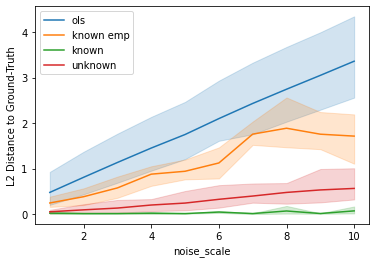

[Text(0.5, 0, 'noise_scale'), Text(0, 0.5, 'L2 Distance to Ground-Truth')]

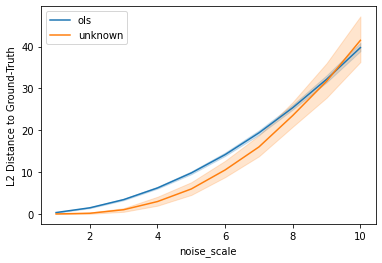

In [25]:
sns.lineplot(data=logs, x='noise_scale', y='ols_param_mse', label='ols')
sns.lineplot(data=logs, x='noise_scale', y='known_emp_param_mse', label='known emp')
sns.lineplot(data=logs, x='noise_scale', y='known_param_mse', label='known')
ax = sns.lineplot(data=logs, x='noise_scale', y='unknown_param_mse', label='unknown')
ax.set(xlabel='noise_scale', ylabel='L2 Distance to Ground-Truth')
plt.show()

sns.lineplot(data=logs, x='noise_scale', y='ols_var_mse', label='ols')
ax = sns.lineplot(data=logs, x='noise_scale', y='unknown_var_mse', label='unknown')
ax.set(xlabel='noise_scale', ylabel='L2 Distance to Ground-Truth')

In [29]:
unknown_var, noise_var

(tensor([[3.6020]], grad_fn=<MulBackward0>), tensor([[10.]]))

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

ax.scatter3D(X[indices][:,0], X[indices][:,1], noised[indices], color="green", alpha=.1)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="red", alpha=.75)

ax.view_init(10, -150)